In [1]:
import random

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from functools import reduce

In [2]:
VERBOSE = 1

BLACK = -1
WHITE =  0


def verbose(msg, *, level=1, end='\n'):
    if VERBOSE >= level:
        print(msg, end=end)

In [94]:
class SampleSource:
    sample_data = [
        {
            'shape': (5, 5),
            'islands': {(1, 0): 1, (2, 4): 3, (3, 3): 4, (4, 0): 2}
        },
        {
            'shape': (5, 5),
            'islands': {(0, 1): 1, (1, 4): 2, (3, 0): 6, (4, 3): 2}
        },

        {
            'shape': (7, 7),
            'islands': {(0, 1): 6, (0, 5): 2, (2, 2): 3, (2, 4): 2, (4, 2): 3, (4, 4): 2, (6, 1): 2, (6, 5): 1}
        },
        {
            'shape': (7, 7),
            'islands': {(0, 6): 9, (2, 3): 6, (3, 4): 4, (4, 3): 3, (6, 6): 1}
        },
        {
            'shape': (10, 10),
            'islands': {(0, 2): 2, (0, 6): 2, (0, 9): 1, (1, 0): 2, (1, 7): 1, (2, 6): 2, (2, 8): 2, (7, 6): 1, (7, 8): 8, (8, 0): 5, (8, 7): 1, (9, 2): 9, (9, 6): 6, (9, 9): 1}
        },        
        {
            'shape': (10, 10),
            'islands': {(1, 7): 2, (2, 1): 5, (2, 9): 4, (3, 2): 9, (3, 8): 2, (4, 1): 2, (6, 1): 1, (7, 0): 2, (7, 2): 8, (8, 4): 3, (8, 8): 1, (9, 2): 1}
        },        
        {
            'shape': (12, 12),
            'islands': {(0, 0): 1, (0, 3): 8, (0, 5): 2, (1, 1): 5, (2, 5): 5, (2, 10): 2, (3, 11): 1, (5, 3): 2, (6, 8): 4, (8, 0): 3, (9, 1): 2, (9, 6): 5, (10, 10): 9, (11, 6): 5, (11, 8): 5, (11, 11): 1}
        },        
        {
            'shape': (15, 15),
            'islands': {(0, 0): 1, (0, 14): 1, (1, 2): 1, (1, 6): 1, (1, 8): 5, (2, 5): 3, (2, 7): 5, (2, 13): 1, (3, 3): 4, (3, 11): 1, (4, 5): 1, (5, 3): 1, (5, 10): 2, (5, 12): 3, (6, 1): 2, (6, 6): 2, (6, 8): 1, (6, 13): 1, (7, 2): 2, (7, 10): 3, (7, 12): 1, (8, 1): 1, (8, 6): 3, (8, 8): 1, (8, 13): 1, (9, 2): 4, (9, 4): 2, (9, 11): 1, (10, 9): 1, (10, 13): 2, (11, 3): 1, (11, 11): 1, (12, 1): 2, (12, 7): 4, (12, 9): 3, (13, 6): 4, (13, 8): 1, (13, 12): 2}
        },        
    ]

    def __len__(self):
        return len(self.sample_data)

    def __getitem__(self, item):
        board = np.zeros(self.sample_data[item]['shape'], dtype=int)
        for coord in self.sample_data[item]['islands'].keys():
            board[coord] = self.sample_data[item]['islands'][coord]
        return board

    def sample(self, number):
        return self.sample_data[number]

In [4]:
def neighbours(coordinate, shape):
    row, col, rows, cols = *coordinate, *shape
    if 0 <= row < rows and 0 <= col < cols:
        if row > 0:
            yield row-1, col
        if col > 0:
            yield row, col-1
        if col < cols-1:
            yield row, col+1
        if row < rows-1:
            yield row+1, col

def neighbours_for_region(region, shape):
    return reduce(lambda x, y: x.union(y), (neighbours(c, shape) for c in region), set()).difference(region)

In [5]:
class BoardSolution:

    def __init__(self, shape, clues, pheromone_matrix):
        self.clues = clues
        self.pheromone_matrix = pheromone_matrix
        self.tiles_to_allocate = sum(clues.values())
        self.board = np.full(shape, BLACK, dtype=int)
        for coord in clues.keys():
            self.board[coord] = clues[coord]

    def score(self):
        missing_tiles = self.tiles_to_allocate - int((np.array(self.board >= 0, dtype=np.uint8).sum()))
        squares = sum((int(np.sum(self.board[r:r + 2, c:c + 2] == BLACK) == 4) for r in range(self.board.shape[0] - 1) for c in range(self.board.shape[1] - 1)))
        return missing_tiles + squares

    def expand_island(self, coord):
        region = {coord}

        def is_fragmented():
            water = np.array(self.board == -1, dtype=np.uint8)
    
            def fill_region(coord):
                if water[coord] == 1:
                    water[coord] = 0
                    for c in neighbours(coord, water.shape):
                        fill_region(c)
    
            r, c = np.argwhere(water == 1)[0]
            fill_region((int(r), int(c)))
            return np.sum(water) > 0
        
        def fragments_board(coord):
            self.board[coord] = WHITE
            result = is_fragmented()
            self.board[coord] = BLACK
            return result

        def choose_one(coordinates):
            # return random.choice(list(coordinates))
            value, pick = 0.0, random.uniform(0, sum(self.pheromone_matrix[c] for c in coordinates))
            for c in coordinates:
                value += self.pheromone_matrix[c]
                if value >= pick:
                    return c
        
        def expand_region():
            if self.board[coord] > len(region):
                adjacent = {c for c in neighbours_for_region(region, self.board.shape) if self.board[c] == BLACK}
                allocated_to_others = {c for c in adjacent for n in neighbours(c, self.board.shape) if self.board[n] != BLACK and n not in region}
                acceptable = {c for c in adjacent.difference(allocated_to_others) if not fragments_board(c)}
                if acceptable:
                    c = choose_one(acceptable)
                    self.board[c] = WHITE
                    region.add(c)
                    expand_region()
        expand_region()

    def solve(self):
        all_islands = [(int(r), int(c)) for r, c in np.argwhere(self.board > 0)]
        random.shuffle(all_islands)
        for coord in all_islands:
            self.expand_island(coord)
        return self.score()


In [108]:
class AntColony:

    ANTS_PER_GENERATION = 10
    GENERATIONS = 300

    LOCAL_PHEROMONE_UPDATE = 0.5
    GLOBAL_EVAPORATION = 0.2
    TAU_EVAPORATION = 0.1

    def __init__(self, shape, islands):
        self.shape = shape
        self.clues = islands
        self.tau0 = 1.0 / sum(islands.values())
        self.pheromone_matrix = np.full(shape, self.tau0, dtype=np.float16)
        self.pheromone_history = [np.copy(self.pheromone_matrix)]
        self.solution = None

    def generation(self, pheromone_matrix):
        best_score, best_solution = reduce(lambda x, y: x * y, self.shape), None
        for _ in range(AntColony.ANTS_PER_GENERATION):
            solution = BoardSolution(self.shape, self.clues, pheromone_matrix)
            score = solution.solve()
            if score == 0:
                return solution
            elif score < best_score:
                best_score, best_solution = score, solution
            verbose('.', end='')
            np.putmask(pheromone_matrix, solution.board >= WHITE, (1.0 - AntColony.LOCAL_PHEROMONE_UPDATE) * pheromone_matrix + AntColony.LOCAL_PHEROMONE_UPDATE * self.tau0)
        return best_solution

    def solve(self):
        tau_best = self.tau0
        for generation in range(AntColony.GENERATIONS):
            verbose(f"Generation: {generation}: ", end='')
            solution = self.generation(np.copy(self.pheromone_matrix))
            score = solution.score()
            if score == 0:
                self.solution = solution
                verbose(" solution found")
                return True
            verbose(f" best score: {score}, pheromone max: {self.pheromone_matrix.max():.4f}")
            tau = 1.0 / score
            if tau > tau_best:
                np.putmask(self.pheromone_matrix, solution.board >= WHITE, ((1.0 - AntColony.GLOBAL_EVAPORATION) * self.pheromone_matrix + AntColony.GLOBAL_EVAPORATION * tau).astype(np.float16))
                self.pheromone_history.append(np.copy(self.pheromone_matrix))
                tau_best = tau
            tau_best = (1.0 - AntColony.TAU_EVAPORATION) * tau_best
        return False


In [112]:
SAMPLE = 2

source = SampleSource()
print(source[SAMPLE])

[[0 6 0 0 0 2 0]
 [0 0 0 0 0 0 0]
 [0 0 3 0 2 0 0]
 [0 0 0 0 0 0 0]
 [0 0 3 0 2 0 0]
 [0 0 0 0 0 0 0]
 [0 2 0 0 0 1 0]]


In [114]:
colony = AntColony(**source.sample(SAMPLE))
colony.solve()

Generation: 0: .......... best score: 3, pheromone max: 0.0476
Generation: 1: .......... best score: 3, pheromone max: 0.1047
Generation: 2: .......... best score: 3, pheromone max: 0.1504
Generation: 3: .......... best score: 3, pheromone max: 0.1870
Generation: 4: .......... best score: 3, pheromone max: 0.2162
Generation: 5: .. solution found


True

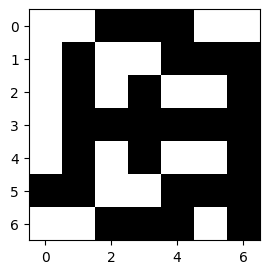

In [115]:
image = (colony.solution.board >= WHITE).astype(np.float16)

fig=plt.figure(figsize=(3, 3))
plt.imshow(image, cmap='gray')
plt.show()

In [116]:
SAMPLE = 5

source = SampleSource()
print(source[SAMPLE])

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0]
 [0 5 0 0 0 0 0 0 0 4]
 [0 0 9 0 0 0 0 0 2 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [2 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 0 0]]


In [118]:
colony = AntColony(**source.sample(SAMPLE))
colony.solve()

Generation: 0: .......... best score: 5, pheromone max: 0.0250
Generation: 1: .......... best score: 9, pheromone max: 0.0600
Generation: 2: .......... best score: 10, pheromone max: 0.0600
Generation: 3: .......... best score: 13, pheromone max: 0.0600
Generation: 4: .......... best score: 4, pheromone max: 0.0600
Generation: 5: .......... best score: 17, pheromone max: 0.0980
Generation: 6: .......... best score: 8, pheromone max: 0.0980
Generation: 7: .......... best score: 7, pheromone max: 0.0980
Generation: 8: .......... best score: 11, pheromone max: 0.0980
Generation: 9: .......... best score: 6, pheromone max: 0.0980
Generation: 10: .......... best score: 5, pheromone max: 0.1117
Generation: 11: .......... best score: 6, pheromone max: 0.1294
Generation: 12: .......... best score: 7, pheromone max: 0.1294
Generation: 13: .......... best score: 8, pheromone max: 0.1294
Generation: 14: .......... best score: 6, pheromone max: 0.1294
Generation: 15: .......... best score: 11, phe

True

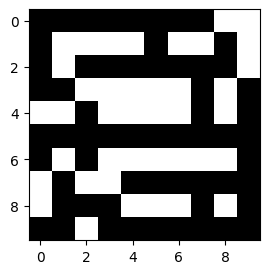

In [119]:
image = (colony.solution.board >= WHITE).astype(np.float16)

fig=plt.figure(figsize=(3, 3))
plt.imshow(image, cmap='gray')
plt.show()

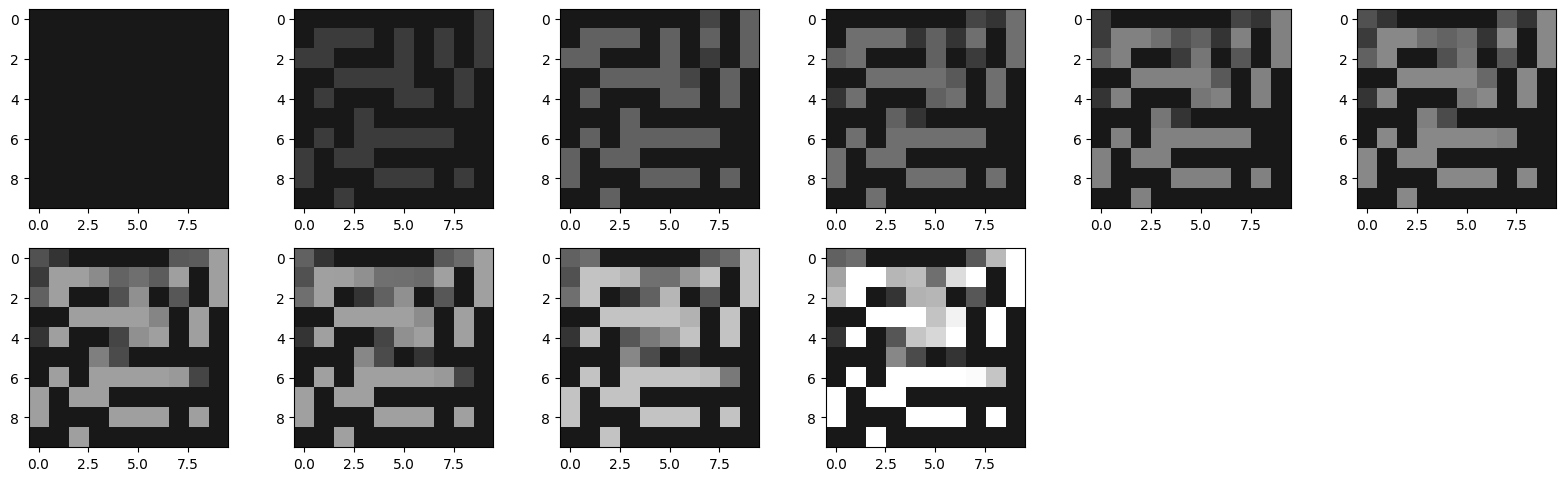

In [120]:
cols = 6
rows = len(colony.pheromone_history) // cols + int(len(colony.pheromone_history) % cols)

image_max_value = max([h.max() for h in colony.pheromone_history])

fig=plt.figure(figsize=(20, 3 * rows))

for i, image in enumerate(colony.pheromone_history, start=1):
    fig.add_subplot(rows, cols, i)
    plt.imshow(image / image_max_value, cmap='gray', norm=matplotlib.colors.NoNorm())
plt.show()

In [121]:
SAMPLE = 6

source = SampleSource()
print(source[SAMPLE])

[[1 0 0 8 0 2 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 4 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 9 0]
 [0 0 0 0 0 0 5 0 5 0 0 1]]


In [122]:
colony = AntColony(**source.sample(SAMPLE))
colony.solve()

Generation: 0: .......... best score: 14, pheromone max: 0.0167
Generation: 1: .......... best score: 27, pheromone max: 0.0276
Generation: 2: .......... best score: 27, pheromone max: 0.0276
Generation: 3: .......... best score: 26, pheromone max: 0.0276
Generation: 4: .......... best score: 33, pheromone max: 0.0276
Generation: 5: .......... best score: 21, pheromone max: 0.0276
Generation: 6: .......... best score: 26, pheromone max: 0.0316
Generation: 7: .......... best score: 22, pheromone max: 0.0316
Generation: 8: .......... best score: 22, pheromone max: 0.0344
Generation: 9: .......... best score: 17, pheromone max: 0.0366
Generation: 10: .......... best score: 22, pheromone max: 0.0410
Generation: 11: .......... best score: 27, pheromone max: 0.0410
Generation: 12: .......... best score: 21, pheromone max: 0.0410
Generation: 13: .......... best score: 22, pheromone max: 0.0423
Generation: 14: .......... best score: 26, pheromone max: 0.0429
Generation: 15: .......... best sco

True

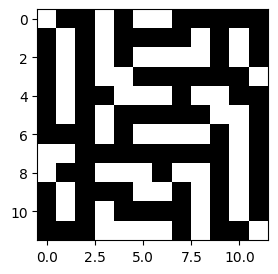

In [123]:
image = (colony.solution.board >= WHITE).astype(np.float16)

fig=plt.figure(figsize=(3, 3))
plt.imshow(image, cmap='gray')
plt.show()

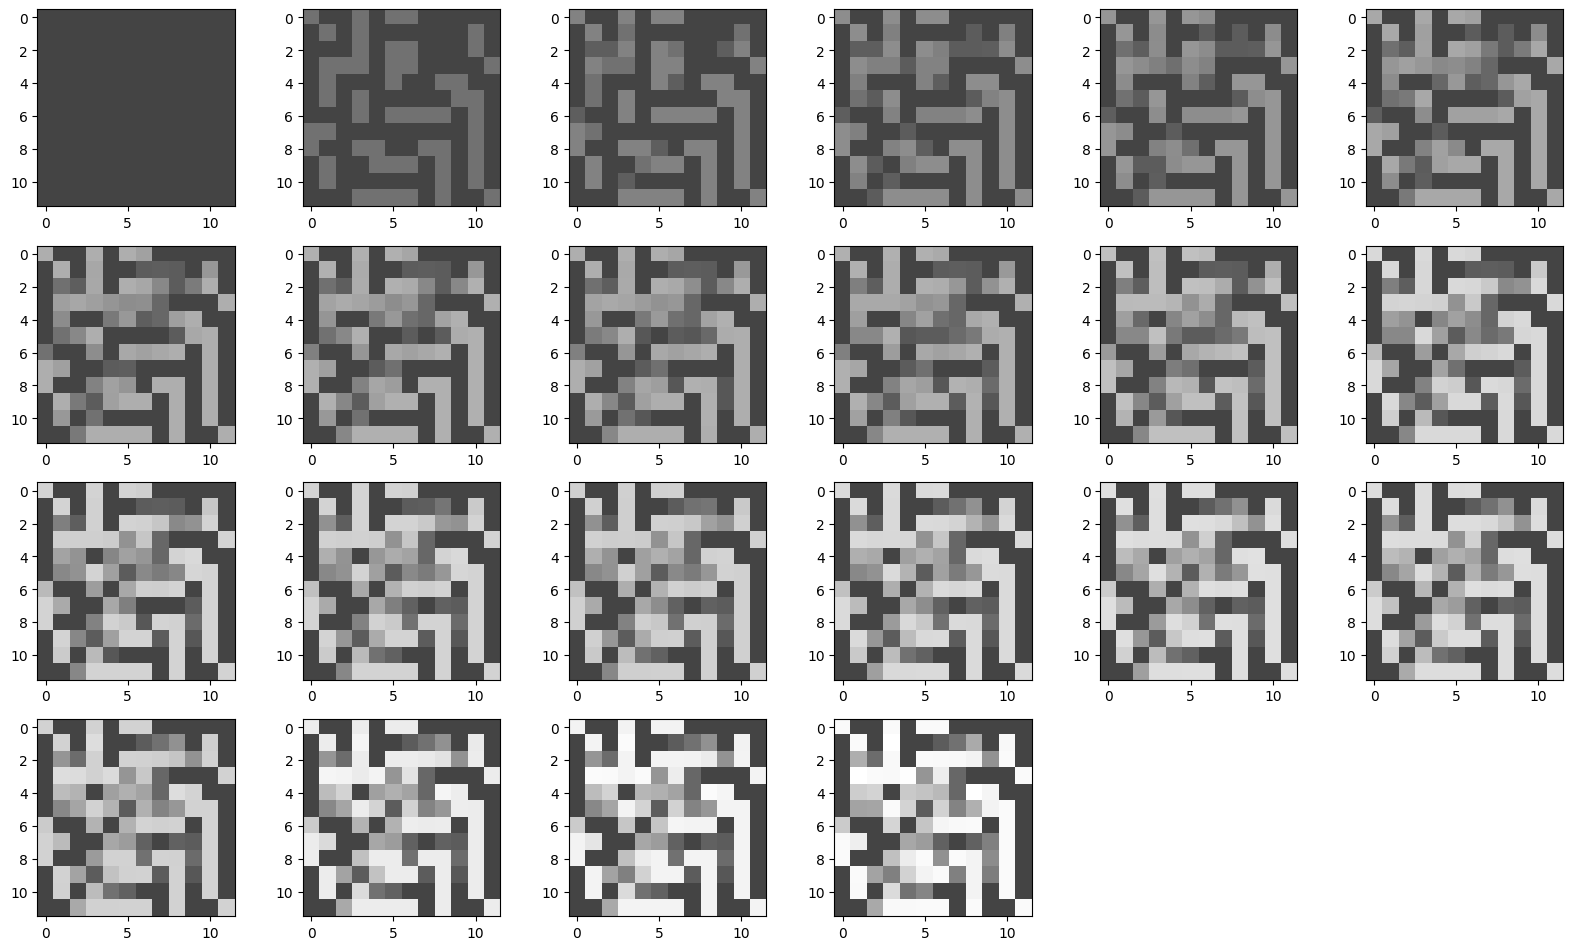

In [124]:
cols = 6
rows = len(colony.pheromone_history) // cols + int(len(colony.pheromone_history) % cols)

image_max_value = max([h.max() for h in colony.pheromone_history])

fig=plt.figure(figsize=(20, 3 * rows))

for i, image in enumerate(colony.pheromone_history, start=1):
    fig.add_subplot(rows, cols, i)
    plt.imshow(image / image_max_value, cmap='gray', norm=matplotlib.colors.NoNorm())
plt.show()